# Modelo GPT - Parte 1

## [Tópicos em Ciência de Dados](https://denmartins.github.io/teaching/2025-topicos-cd)

### [Prof. Dr. Denis Mayr Lima Martins](https://denmartins.github.io/)

### [Pontifícia Universidade Católica de Campinas](https://www.puc-campinas.edu.br/)

<img src="https://www.puc-campinas.edu.br/wp-content/uploads/2022/06/logo-puc.png" width="100px"/>


# Objetivos de Aprendizagem

- Implementar um modelo de LLM semelhante ao GPT que pode ser treinado para gerar texto.
- Compreender o conceito de normalização de camadas e sua importância no treinamento de redes neurais.
- Entender como conexões de atalho (skipping connections) em redes neurais profundas ajudam no treinamento.
- Implementar blocos Transformer para criar modelos GPT de diferentes tamanhos

<center>
<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
Baseado no Livro <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> de <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="200px"></a>
</td>
</tr>
</table>
</center>

# Parte 1

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

- `import os`: Importa o módulo *os* para interagir com o sistema operacional.  
- `os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"`: Define uma variável de ambiente que instrui a biblioteca MKL da Intel a permitir que múltiplas instâncias da mesma biblioteca sejam carregadas simultaneamente, sem gerar erro. Tal configuração costuma ser empregada para resolver conflitos entre bibliotecas em tarefas de computação científica ou aprendizado de máquina.

In [2]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.5
torch version: 2.8.0
tiktoken version: 0.11.0


# 1. Codificando uma Arquitetura de LLM

- Modelos de linguagem de larga escala (LLMs), como o GPT, são arquiteturas de redes neurais profundas projetadas para gerar novo texto palavra (ou token) por palavra. Apesar do tamanho, a arquitetura do modelo é menos complicada do que se imagina, já que muitos de seus componentes são repetidos.
- A arquitetura de um GPT contém, ao lado das camadas de embedding, blocos *transformer* que incluem o módulo de atenção multi-cabeças mascarada implementado anteriormente.


In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers/transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- **`"vocab_size"`** tamanho de vocabulário de 50257 palavras, suportado pelo tokenizador BPE.  
- **`"context_length"`** contagem máxima de tokens de entrada do modelo, conforme habilitado pelos embeddings posicionais.  
- **`"emb_dim"`** tamanho do embedding para os tokens de entrada, convertendo cada token de entrada num vetor de 768 dimensões.  
- **`"n_heads"`** número de cabeças de atenção no mecanismo de multi‑head attention.  
- **`"n_layers"`** número de blocos transformer dentro do modelo, que iremos implementar em breve.  
- **`"drop_rate"`** descarta 10% das unidades ocultas durante o treinamento para mitigar overfitting.  
- **`"qkv_bias"`** decide se as camadas `Linear` no mecanismo de MHA devem incluir um vetor de bias ao calcular os tensores query (Q), key (K) e value (V); desativaremos essa opção, prática padrão em LLMs modernos.

## Implementação Principal

Arquitetura inicial chamada que serve como esqueleto do modelo.

In [4]:
import torch
import torch.nn as nn

class SimpleGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(
            cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[SimpleTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = SimpleLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Camadas adicionais

In [5]:
class SimpleTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Um placeholder simples

    def forward(self, x):
        # Este bloco não faz nada e apenas retorna sua entrada.
        return x

class SimpleLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # Os parâmetros aqui são apenas para imitar 
        # a interface do LayerNorm.

    def forward(self, x):
        # Esta camada não faz nada e apenas retorna sua entrada.
        return x

A classe `SimpleGPTModel` presente neste código define uma versão simplificada de um modelo do tipo GPT utilizando o módulo de redes neurais do PyTorch (`nn.Module`). A arquitetura do modelo na classe `SimpleGPTModel` consiste em embeddings de token e posicional, dropout, uma série de blocos transformadores (`SimpleTransformerBlock`), normalização de camada final (`SimpleLayerNorm`) e uma camada linear de saída (out_head). A configuração é passada por meio de um dicionário Python; por exemplo, o dicionário `GPT_CONFIG_124M` que criamos anteriormente.  

O método `forward` descreve o fluxo de dados através do modelo: ele calcula os embeddings de token e posicional para os índices de entrada, aplica dropout, processa os dados pelos blocos transformadores, aplica a normalização e, finalmente, gera logits com a camada linear de saída.  

O código já é funcional, como veremos mais adiante após prepararmos os dados de entrada. Entretanto, atualmente utilizamos placeholders (`SimpleLayerNorm` e `SimpleTransformerBlock`) para o bloco transformador e a normalização de camada.  

Em seguida, prepararemos os dados de entrada e inicializaremos um novo modelo GPT para ilustrar seu uso. Construindo sobre as figuras que vimos no episódio em que codificamos o tokenizador, a figura abaixo fornece uma visão geral de alto nível de como os dados entram e saem de um modelo GPT.

## Visão Geral

<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/e065aaca707d5039aea24d8752be69ab78a7b19028724cfacf0902d8b46ae9ed/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30342e776562703f313233' alt='Visão Geral da Arquitetura GPT' style="width:500px;"/>
    <span style='display:block;'> Visão Geral da Arquitetura GPT. Fonte: <a href="https://magazine.sebastianraschka.com" target="_blank">Ahead of AI</a>.</span>
    <br/>
</div>

## Tokenização

A saída do código abaixo é o que a LLM recebe, e a tarefa consiste em produzir a próxima palavra desse texto.

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"  # every word will result in a token
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## Instanciando o Modelo

Inicializamos uma nova instância do `SimpleGPTModel` com 124 milhões de parâmetros conforme especificado acima e alimentamos o modelo com o lote tokenizado (os resultados do modelo são comumente denominados *logits*).

In [7]:
torch.manual_seed(123)
model = SimpleGPTModel(GPT_CONFIG_124M)  
logits = model(batch)                   
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


O tensor de saída possui duas linhas correspondentes às duas amostras de texto. Cada amostra consiste em 4 tokens (um para cada palavra); cada token é um vetor de 50257 dimensões, o que corresponde ao tamanho do vocabulário do tokenizador.

Embeddings tem 50257 dimensões porque cada uma dessas dimensões representa um token único no vocabulário. Ao final deste episódio, quando implementarmos o código de pós‑processamento, converteremos esses vetores de 50257 dimensões de volta em IDs de token, que então poderemos decodificar em palavras.

## 2. Layer Normalization


Usamos a normalização de camada para melhorar a estabilidade e eficiência do treinamento de redes neurais. 
- **Ideia central**: ajustar as ativações (saídas) de uma camada de rede neural de modo que tenham média zero e variância unitária, também conhecida como *unit variance*. 
- **Vantagem**: Acelera a convergência para pesos efetivos e garante um treinamento consistente e confiável. 
- Nas arquiteturas GPT‑2 e nos transformers, a normalização de camada costuma ser aplicada antes e depois do módulo de atenção multi‑cabeça e antes da camada de saída final.


<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/1bb0018e68d16529b969ccc6b0bca371ed5a7b9a514d1bd3f345c4941c0f463d/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30352e77656270' alt='Layer Normalization' style="width:600px;"/>
    <span style='display:block;'> Layer Normalization. Fonte: <a href="https://magazine.sebastianraschka.com" target="_blank">Ahead of AI</a>.</span>
    <br/>
</div>


Vamos observar como funciona a normalização de camada passando uma pequena amostra de entrada por uma camada neural simples; especificamente, recriamos o exemplo ilustrado na figura acima através do código seguinte, no qual implementamos uma camada neural com 5 entradas e 6 saídas que aplicaremos a dois exemplos de entrada.

In [8]:
torch.manual_seed(123)

# Cria 2 exemplos de treino com 5 features cada
batch_example = torch.randn(2, 5) 
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [9]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [10]:
# -1 torna invariante contra dimensões adicionais
mean = out.mean(dim=-1, keepdim=True) 
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


### Ilustrando o cálculo

<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/1d353a009cf6ec3a2ea918b62bfedc10b565e0d17836366fc0e5dffca6156715/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30362e77656270' alt='dim=-1 em Layer Normalization' style="width:600px;"/>
    <span style='display:block;'>dim=-1 em Layer Normalization. Fonte: <a href="https://magazine.sebastianraschka.com" target="_blank">Ahead of AI</a>.</span>
    <br/>
</div>

In [11]:
# Aplica a normalização de camada aos resultados da camada anterior
# Consiste em subtrair a média e dividir pelo desvio padrão.
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

# melhora a visualização
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Layer Norm (módulo)

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):  # valores na dimensão do embedding
        super().__init__()
        self.eps = 1e-5
        # isso torna os valores treináveis
        self.scale = nn.Parameter(torch.ones(emb_dim))  
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)  # eps evita divisão por zero
        return self.scale * norm_x + self.shift

        # shift não tem efeito aqui pois adiciona apenas zero; 
        # será relevante mais tarde durante o treinamento,
        # permitindo que a rede desfaça essa normalização; 
        # similarmente para scale

### Layer Norm (aplicação)

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
out_ln

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

In [14]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Parte 2

# Modelo GPT - Parte 2

## [Tópicos em Ciência de Dados](https://denmartins.github.io/teaching/2025-topicos-cd)

### [Prof. Dr. Denis Mayr Lima Martins](https://denmartins.github.io/)

### [Pontifícia Universidade Católica de Campinas](https://www.puc-campinas.edu.br/)

<img src="https://www.puc-campinas.edu.br/wp-content/uploads/2022/06/logo-puc.png" width="100px"/>


<center>
<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
Baseado no Livro <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> de <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="200px"></a>
</td>
</tr>
</table>
</center>

## Recapitulando a aula passada

<div style='align: left; text-align:center;'>
    <img src='https://lilianweng.github.io/lil-log/assets/images/OpenAI-GPT-transformer-decoder.png' alt='Transformer' style="height:400px;"/>
    <span style='display:block;'>Arquitetura Transformer. Fonte: <a href="https://lilianweng.github.io" target="_blank">https://lilianweng.github.io</a>.</span>
    <br/>
</div>


<div style='align: left; text-align:center;'>
    <img src='https://substackcdn.com/image/fetch/$s_!JOyz!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F5a0a1e39-de22-4a95-8a42-b4040cf33b54_2040x956.png' alt='Post-LN versus Pre-LN' style="width:100%; height:100%;"/>
    <span style='display:block;'>Post-LN versus Pre-LN. Fonte: <a href="https://magazine.sebastianraschka.com/p/understanding-large-language-models" target="_blank">Ahead of AI</a>.</span>
    <br/>
</div>

- [Attention is All you Need](https://arxiv.org/abs/1706.03762) usa Post-LN.
- [Layer Normalization in the Transformer Architecture](https://arxiv.org/abs/2002.04745) sugere que Pre-LN funciona melhor para problemas com gradientes.
- [ResiDual: Transformer with Dual Residual Connections](https://arxiv.org/abs/2304.14802) se vale das duas abordagens, mas ainda há bastante discussão sobre o tema. 

## Aspectos Gerais de Arquitetura de LLMs

<div style='align: left; text-align:center;'>
    <img src='https://substackcdn.com/image/fetch/$s_!L-Fu!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fcf0be27f-4d1b-4761-9019-b04735c3bd25_1854x648.jpeg' alt='Aspectos Gerais de Arquitetura de LLMs' style="width:700px;"/>
    <span style='display:block;'> Pythia: A Suite for Analyzing Large Language Models Across Training and Scaling (2023). Fonte: <a href="https://magazine.sebastianraschka.com/p/understanding-large-language-models" target="_blank">Ahead of AI</a>.</span>
    <br/>
</div>


## Feed-Forward com Ativação GELU

---

Vamos implementar uma camada composta de uma pequena rede neural que será usada como parte do bloco Transfomer nos LLMs.

Iniciaremos com a função de ativação.

<center>

<h3> Por que precisamos de funções de ativação não-lineares em Redes Neurais?</h3>

</center>



<div style='align: left; text-align:center;'>
    <img src='https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEi_62ZJVAenaC_Zlir7nlXQTj9F3Hf6IyE0xXD1buQdcIbir_EZWSHy0hhswTvjgP5lS-kuCRXNwqTK1vtp0xlFLAp_kQ5adjwyU87Ery6aFYcoGnT_xZOM_2HpSWs8MHaq_mnkHqFMaU8/s1600/Picture10.png' alt='Activation Function' style="width:700px;"/>
    <span style='display:block;'>Importância das funções de ativação não-lineares. Fonte: <a href="https://anjali-dl.blogspot.com/2020/03/importance-of-activation-functions.html" target="_blank">Anjali Kumari</a>.</span>
    <br/>
</div>



## Feed-Forward com Ativação GELU

- A função de ativação é a transformação não linear que fazemos ao longo do sinal de entrada. 
- Quando não temos a função de ativação, os pesos e bias simplesmente fazem uma transformação linear. Uma equação linear é simples de resolver, mas é limitada na sua capacidade de resolver problemas complexos.
- Introduzir não‑linearidade nos neurônios, permitindo que redes profundas capturem padrões complexos e façam classificações em múltiplas classes.

### **GELU (Gaussian Error Linear Unit)**
---

- Presente nas arquiteturas GPT-2/3
- **Definição matemática**: $\text{GELU}(x) = x \cdot \Phi(x)$, onde $\Phi(x)$ é a função de distribuição acumulada da normal padrão.  
- **Propriedades**:  
  - Se comporta como identidade para valores positivos (mantém quase todos os sinais).  
  - Para valores negativos, atenua suavemente o valor em vez de cortá‑lo abruptamente como ReLU.
- **Aproximação prática** (usada na maioria das implementações):  
  $$
  \text{GELU}(x) \approx 0.5\,x\,[1 + \tanh(\sqrt{\frac{2}{\pi}}(x + 0.044715x^{3}))]
  $$
- Evita o cálculo direto de funções exponenciais, reduzindo a carga computacional.



In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [16]:
import matplotlib.pyplot as plt
import torch                       
import torch.nn as nn              

gelu, relu = nn.GELU(), nn.ReLU()

# Cria dados simples para plotar as funções
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

### GELU x RELU

O que acontece com os gradientes nas duas funções?


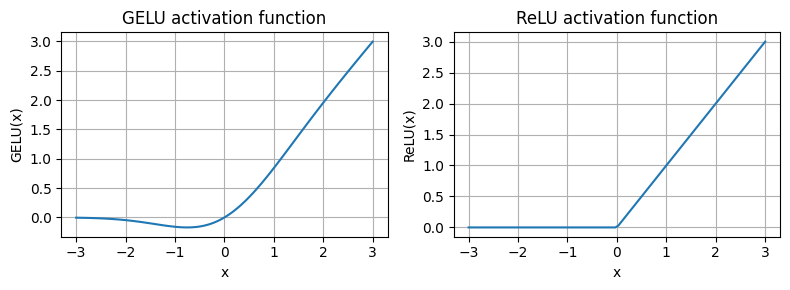

In [17]:
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

### GELU: Vantagem 

- Fornece resposta mais gradual ao redor do ponto morto, evitando saltos abruptos na saída quando a entrada cruza zero; pode melhorar a estabilidade numérica.
- Gradientes não-zero para valores negativos.

## Rede Feed-Forward
---

Usamos GELU na implementação da camada Feed-Forward com duas camadas lineares.

In [18]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

A camada Feed-Forward é crucial para melhorar a habilidade do modelo de generalizar os dados. Embora entrada e saída ambos tenham a mesma dimensionalidade, a camada escondida expande a dimensionalidade dos embeddings a um espaço dimensional muito maior.

<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/5b893aa5271d2f828f427f33208e4eadc1429c26c9bf4d2a1760b1384b1eeebc/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30392e776562703f3132' alt='Dimensionalidade dos Vetores' style="width:450px;"/>
    <span style='display:block;'>Dimensionalidade dos Vetores. Fonte: <a href="https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb" target="_blank">Sebastian Raschka</a>.</span>
    <br/>
</div>




## 4. Conexões de Atalho (*Residual Connections*)

---

<center>
<table style="width:100%;border:none;">
<tr>
<td style="vertical-align:middle;text-align:left;border:none;width:40%;">

- Propostas originalmente para mitigar os problemas do desaparecimento do gradiente. 
- Ideia: Adicionar a saída de uma camada à saída de uma camada posterior, geralmente pulando (*skipping*) uma ou mais camadas no meio.
- Uma conexão atalho cria um caminho alternativo e mais curto para o gradiente fluir através da rede. 

</td>
<td style="vertical-align:middle;text-align:left;border:none;">
<img src="https://camo.githubusercontent.com/b1cb95fee4a11c35cb6ce14a2399ac09875c45dc92d344713a80913e05e04c20/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31322e776562703f313233" width="100%">
</td>
</tr>
</table>
</center>

In [19]:
class SimpleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(
                nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(
                nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(
                nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(
                nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            # Verifica se o atalho pode ser aplicado
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [20]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])  # a placeholder for computing the loss, i.e., the difference between the output and the target

    # Calcular a perda com base 
    # na proximidade do alvo e da saída
    loss = nn.MSELoss()
    loss = loss(output, target)  # later the loss function will be the next token generated
    
    # Backward pass para calcular gradientes
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Imprimir a média absoluta do gradiente dos pesos
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

### Gradientes **sem** conexões de atalho

In [21]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = SimpleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


### Gradientes **com** conexões de atalho

In [22]:
torch.manual_seed(123)
model_with_shortcut = SimpleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## 5. Bloco Transformer

---

Agora, combinamos os conceitos anteriores em um *bloco transformer*:


<div style='align: left; text-align:center;'>
    <img src='https://camo.githubusercontent.com/6c8c392f72d5b9e86c94aeb9470beab435b888d24135926f1746eb88e0cc18fb/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31332e776562703f31' alt='Visão Geral GPT-2' style="width:400px;"/>
    <span style='display:block;'>Visão Geral GPT-2. Fonte: <a href="https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb" target="_blank">Sebastian Raschka</a>.</span>
    <br/>
</div>

![]()



A parte inferior do diagrama mostra tokens que foram incorporados em vetores de 768 dimensões. Cada linha corresponde à representação vetorial de um token. As saídas do bloco transformer são vetores da mesma dimensão que a entrada, que podem então ser alimentados em camadas subsequentes em um LLM.

Quando um bloco transformer processa uma sequência de entrada, cada elemento na sequência (por exemplo, uma palavra ou token subpalavra) é representado por um vetor de tamanho fixo (aqui 768 dimensões). As operações dentro do bloco transformer, incluindo a atenção multi-cabeças e as camadas feed forward, são projetadas para transformar esses vetores de uma forma que preserve sua dimensionalidade.

A ideia é que o mecanismo de autoatenção no bloco de atenção multi-cabeças identifica e analisa relacionamentos entre elementos na sequência de entrada. Em contraste, a rede feed forward modifica os dados individualmente em cada posição. Essa combinação não apenas permite uma compreensão e processamento mais refinados da entrada, mas também aprimora a capacidade geral do modelo para lidar com padrões de dados complexos.

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)

        # Implicitamente dividimos a matriz adicionando uma dimensão `num_heads`
        # Desenrolla a última dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calcula a atenção de produto escalar escalonado (também conhecida como auto-atenção) com uma máscara causal
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        
        # Máscara original truncada ao número de tokens e convertida para booleana
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Usa a máscara para preencher as pontuações de atenção
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combina as cabeças, onde self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Adiciona a entrada original de volta
        
        shortcut = x # Conexão de atalho
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Adiciona a entrada original de volta

        return x

O código acima inclui:

*   **Definição da Classe `TransformerBlock`:** A classe implementa um bloco transformador em PyTorch, combinando mecanismos de atenção multi-cabeça e redes feed forward.
*   **Configuração Baseada em Dicionário:** A configuração de ambos os componentes (atenção e feed forward) é feita através de um dicionário de configuração, como `GPT_CONFIG_124M`.
*   **Normalização e Dropout:** A normalização de camada (LayerNorm) é aplicada antes dos componentes, enquanto o dropout é aplicado após para regularização e prevenção de overfitting.
*   **Conexões de Atalho (Skip Connections):**  O bloco implementa conexões de atalho que adicionam a entrada do bloco à sua saída. Isso facilita o fluxo dos gradientes durante o treinamento e melhora a aprendizagem em modelos profundos.

In [25]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 6. Modelo GPT

- Vamos integrar o bloco Transformer na arquitetura GPT e montar uma versão totalmente funcional da versão original de 124 milhões de parâmetros do GPT-2.
-   **Tokenização e Embeddings:** O texto tokenizado é convertido em embeddings de tokens, que são então combinados com embeddings posicionais.
-   **Empilhamento de Blocos Transformadores:** O tensor resultante é processado por uma série de 12 blocos transformadores empilhados, cada um contendo camadas de atenção multi-cabeça e redes neurais feed forward com dropout e normalização de camada.


In [26]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(
            cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(
            cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device))
        # Shape [batch_size, num_tokens, emb_size]
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Saída do Modelo GPT

O tensor de saída tem a forma [2, 4, 50257], já que passamos 2 textos de entrada com 4 tokens cada. A última dimensão, 50257, corresponde ao tamanho do vocabulário do tokenizador. Abaixo veremos como converter cada um desses vetores de saída 50257-dimensional de volta para tokens.

In [27]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
batch.shape

print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


### Número de Parâmetros

O modelo tem 163M, e não 124M parâmetros 

**Amarração de pesos** (weight tying): compartilhamento de pesos que é usado na arquitetura original do GPT-2, o que significa que a arquitetura original do GPT-2 está reutilizando os pesos da camada de embedding de token (`tok_emb`) em sua camada de saída, definindo assim `self.out_head.weight = self.tok_emb.weight`.


In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


### Número de Parâmetros (cont.)

Como podemos ver com base nas saídas de impressão, os tensores de peso para ambas essas camadas têm a mesma forma.

In [29]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


### Número de Parâmetros (cont.)

Vamos remover a contagem de parâmetros da camada de saída da contagem total do modelo GPT-2, de acordo com a amarração de pesos:

In [30]:
out_head_params = sum(
    p.numel() for p in model.out_head.parameters())

total_params_gpt2 =  total_params - out_head_params

print(f"Params. treináveis (weight tying): {total_params_gpt2:,}")

Params. treináveis (weight tying): 124,412,160


### Consumo de memória

A amarração de pesos reduz a pegada geral de memória e a complexidade computacional do modelo. No entanto, o uso de camadas separadas de embedding de token e saída resulta em melhor treinamento e desempenho do modelo.

Podemos calcular os requisitos de memória do modelo da seguinte forma:

In [31]:
# Calcula o tamanho total em bytes 
# (assumindo float32, 4 bytes por parâmetro)
total_size_bytes = total_params * 4
# Converte para megabytes
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Tamanho total do modelo: {total_size_mb:.2f} MB")

Tamanho total do modelo: 621.83 MB


## 7. Gerando Texto

---

<center>
<table style="width:100%;border:none;">
<tr>
<td style="vertical-align:middle;text-align:left;border:none;width:40%;">

- **Autoregessivo**: Começando com um contexto de entrada inicial, o modelo estima um token subsequente em cada iteração, anexando-o ao contexto de entrada para a próxima rodada de previsão.
-  O processo pelo qual um modelo GPT vai dos tensores de saída para o texto gerado envolve várias etapas que incluem decodificar os tensores de saída, selecionar tokens com base em uma distribuição de probabilidade e converter esses tokens em texto legível por humanos.

</td>
<td style="vertical-align:middle;text-align:left;border:none;">
<img src="https://camo.githubusercontent.com/be7b35733665766c48c64f651586173df9d1dd3a9ca985eca3593df5355db6a1/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31362e77656270" width="400">
</td>
</tr>
</table>
</center>



In [32]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx é um array (batch, n_tokens) de índices no contexto atual
    for _ in range(max_new_tokens): # quantas tokens você quer gerar
        # Trunca o contexto atual se ele exceder 
        # o tamanho de contexto suportado
        # Ex: se LLM suporta apenas 5 tokens, 
        #  e o tamanho do contexto é 10 então 
        #  apenas os últimos 5 tokens são usados como contexto
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Foca apenas no último passo de tempo
        # (batch, n_tokens, vocab_size) se torna (batch, vocab_size)
        logits = logits[:, -1, :] 

        # Aplica softmax para obter probabilidades
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Obtém o idx do vocabulário com maior probabilidde
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) 
        # argmax retorna a posição de índice do valor mais alto

        # Anexa o índice amostrado à sequência em execução
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


## Texto de Entrada (Contexto)

In [33]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


### Geração de Texto

Note que como não treinamos o modelo ainda, o resultado um texto sem sentido.

In [34]:
model.eval() # Desabilita dropout
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue


# Próximos Passos

- Experimentar com Pre-LN x Post-LN.
- Modifique as configurações do modelo GPT-2 implementado aqui.
- Analisar as diferenças entre GPT-2 e modelos mais modernos como o GPT-OSS.

<center>

<img src="https://substackcdn.com/image/fetch/$s_!-dhg!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa8fb9d66-b650-441c-a2da-a0931fddb068_1425x769.png" width="600">
</td>

</center>